In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
import datetime
import os
from omegaconf import OmegaConf, DictConfig, ListConfig

import geopandas as gpd
from shapely.geometry import Point

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

from sklearn.metrics.pairwise import haversine_distances

from geopy.distance import great_circle

from shapely.geometry import MultiPoint

from tqdm import tqdm


from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="..\\scripts\\config\\"):
    cfg = compose(config_name='config.yaml')

HW CLASSIFICATION

In [10]:
launch_time = cfg.launch_time
cluster_data = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\labeled_cluster_data_{launch_time}.csv", index_col=0)
df = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\data_with_clusters_{launch_time}.csv", index_col=0)


In [11]:
SEC_IN_DAY = 60 * 60 * 24
df['day_ts'] = df['ts'] % (SEC_IN_DAY)

In [12]:
cluster_data.head()

id      lat      lon  cluster  cluster_size           inq  wd_rate   
0   2.0  54.8436  38.1929      0.0        5056.0  46681.775000     1.00  \
1   6.0  54.9034  38.0696      0.0         989.0  15146.533333     0.75   
2   6.0  54.8933  38.0780      1.0         830.0  39723.665414     1.00   
5  13.0  54.8428  38.1908      0.0        2908.0  38369.617647     1.00   
6  14.0  54.8419  38.1885      0.0        2213.0  35349.094340     1.00   

     wd_all  work_place  
0  1.000000       False  
1  0.428571        True  
2  0.571429       False  
5  1.000000       False  
6  1.000000       False

In [13]:
df.head()

lat      lon            ts   id  length  cluster    log_date   day_ts
0  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21  14340.0
1  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21  14341.0
2  54.8435  38.1928  1.674846e+09  2.0  1005.0        0  2023-01-27  68883.0
3  54.8435  38.1928  1.674848e+09  2.0  1005.0        0  2023-01-27  70390.5
4  54.8435  38.1928  1.674849e+09  2.0  1005.0        0  2023-01-27  71898.0

In [85]:
# cluster_data['work_place'] = (cluster_data['inq'] < 28500) & (cluster_data['inq'] > 14000) | (cluster_data['inq'] > 40000) & (cluster_data['inq'] < 45000)

Первый способ: рабочий кластер, если на него пришлось меньше половины суммарного количества дней по всем кластерам пользователя, либо, если выше половины, размах меньше 25к секунд

In [226]:
WD_ALL_THRESH = cfg.wd_all_thresh
INQ_THRESH = cfg.inq_thresh
cluster_data['work_place'] = (cluster_data['wd_all'] < WD_ALL_THRESH) | ((cluster_data['wd_all'] >=WD_ALL_THRESH) & (cluster_data['inq'] < INQ_THRESH))

Второе правило

cluster_data['work_place'] = (cluster_data['wd_rate'] < 0.7) | ((cluster_data['wd_rate'] >= 0.7) & (cluster_data['inq'] < 30000))

In [214]:
cluster_data

id      lat      lon  cluster  cluster_size           inq wd_rate  \
0         2.0  54.8436  38.1929      0.0        5056.0     46681.775     1.0   
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333    0.75   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414     1.0   
5        13.0  54.8428  38.1908      0.0        2908.0  38369.617647     1.0   
6        14.0  54.8419  38.1885      0.0        2213.0   35349.09434     1.0   
...       ...      ...      ...      ...           ...           ...     ...   
5355  36014.0  54.8840  38.0581      0.0        1399.0  31713.003268     1.0   
5356  36099.0  54.9429  38.0713      0.0        3069.0  28944.586667     1.0   
5358  36365.0  54.9423  38.1347      0.0        3963.0   33879.40293     1.0   
5363  36721.0  54.8860  38.0891      0.0        2429.0  36563.291667     1.0   
5365  37192.0  54.8448  38.1918      0.0        3194.0  33701.266667     1.0   

        wd_all  work_place  
0          1.0       False  
1     0.428571        True  
2     0.571429        True  
5          1.0       False  
6          1.0       False  
...        ...         ...  
5355       1.0       False  
5356       1.0        True  
5358       1.0       False  
5363       1.0       False  
5365       1.0       False  

[2835 rows x 9 columns]

<AxesSubplot: >

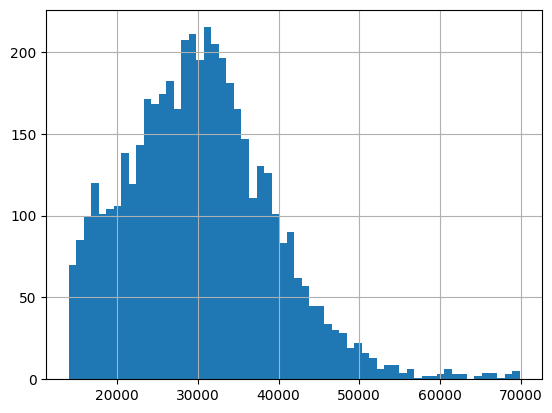

In [23]:
cluster_data['inq'].hist(bins=60)

In [24]:
cluster_data['work_place'].value_counts()

work_place
False    2977
True     1776
Name: count, dtype: int64

In [25]:
geometry = [Point(xy) for xy in zip(cluster_data['lon'], cluster_data['lat'])]
gdf = gpd.GeoDataFrame(cluster_data, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

# Исследование на отдельных пользователях

In [53]:
cur_id = 13666
cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
data = cur_id_df[(pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5)].copy()
cur_cluster_data = cluster_data[cluster_data['id'] == cur_id]
cur_cluster_data

id      lat      lon  cluster  cluster_size           inq  wd_rate   
4065  13666.0  54.8997  38.0855      0.0        4966.0  30118.196434      0.7  \
4066  13666.0  54.8983  38.0228      1.0        3416.0  27836.914786      0.6   

        wd_all  work_place  
4065  0.538462       False  
4066  0.461538        True

In [37]:
cur_id_df

lat      lon            ts   id  length  cluster    log_date   
5204  54.9034  38.0696  1.676272e+09  6.0   516.5        0  2023-02-13  \
5205  54.9034  38.0696  1.676273e+09  6.0   516.5        0  2023-02-13   
5206  54.9034  38.0696  1.676273e+09  6.0   516.5        0  2023-02-13   
5207  54.9034  38.0696  1.676274e+09  6.0   516.5        0  2023-02-13   
5208  54.9034  38.0696  1.676274e+09  6.0   516.5        0  2023-02-13   
...       ...      ...           ...  ...     ...      ...         ...   
7101  54.8933  38.0780  1.676102e+09  6.0   335.1        1  2023-02-11   
7102  54.8933  38.0780  1.676102e+09  6.0   335.1        1  2023-02-11   
7103  54.8933  38.0780  1.676102e+09  6.0   335.1        1  2023-02-11   
7104  54.8933  38.0780  1.676661e+09  6.0   195.0        1  2023-02-17   
7105  54.8933  38.0780  1.676662e+09  6.0   195.0        1  2023-02-17   

            day_ts  
5204  25505.000000  
5205  26124.800000  
5206  26744.600000  
5207  27364.400000  
5208  27984.200000  
...            ...  
7101  28022.333333  
7102  28394.666667  
7103  28767.000000  
7104  69283.000000  
7105  69673.000000  

[1819 rows x 8 columns]

In [38]:
for cluster in data['cluster'].unique():
    print(cluster, data.groupby(['cluster', 'log_date'])[['length']].sum().stack()[cluster].median())

0 21820.0
1 7396.0


In [39]:
data.groupby(['cluster', 'log_date'])[['length']].sum().stack()

cluster  log_date          
0        2023-02-01  length    19843.0
         2023-02-02  length    24126.0
         2023-02-03  length    14342.0
         2023-02-06  length    21409.0
         2023-02-07  length    21820.0
         2023-02-13  length    35109.0
         2023-02-17  length    25440.0
         2023-02-20  length    47610.0
         2023-02-21  length    19426.0
1        2023-01-31  length     2593.0
         2023-02-01  length     6114.0
         2023-02-02  length    11121.0
         2023-02-03  length    13493.0
         2023-02-06  length     8678.0
         2023-02-07  length      949.0
         2023-02-09  length    27015.0
         2023-02-13  length     1807.0
         2023-02-17  length     4404.0
         2023-02-20  length     2868.0
         2023-02-21  length    11584.0
         2023-02-23  length    21228.0
dtype: float64

(0.0, 80000.0)

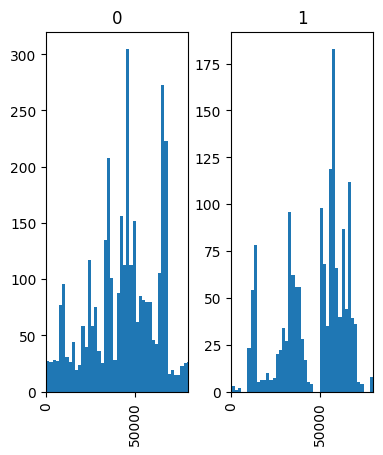

In [54]:
ax_list = data['day_ts'].hist(layout=(1,3), by=data['cluster'], bins=48)
ax_list[0].set_xlim((0, 80000))
ax_list[1].set_xlim((0, 80000))
ax_list[2].set_xlim((0, 80000))


In [41]:
cur_id_df.groupby('cluster')['log_date'].nunique()

cluster
0     9
1    13
Name: log_date, dtype: int64

In [42]:
cur_id_df['log_date'].nunique()

13

In [43]:
geometry = [Point(xy) for xy in zip(cur_cluster_data['lon'],cur_cluster_data['lat'])]
gdf = gpd.GeoDataFrame(cur_cluster_data , geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [44]:
geometry = [Point(xy) for xy in zip(cur_id_df['lon'], cur_id_df['lat'])]
gdf = gpd.GeoDataFrame(cur_id_df, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='cluster', cmap=['blue', 'green', 'red', 'orange'])

In [48]:
ddd = df.query('id == @cur_id').copy()
geometry = [Point(xy) for xy in zip(ddd ['lon'], ddd ['lat'])]
gdf = gpd.GeoDataFrame(ddd , geometry=geometry, crs=4326)
# gdf.explore(cmap=['blue'])
gdf.explore(categorical=True, column='cluster', cmap=['blue', 'green', 'red', 'orange'])